## Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

    1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
    2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных 
    определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
    3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Задание 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Приступим.
Первым делом подгрузим имеющиемся данные, посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных, поменяем типы данных, если это необходимо.

In [2]:
reg = pd.read_csv(r'shared/problem1-reg_data.csv', sep = ';')
auth = pd.read_csv(r'shared/problem1-auth_data.csv', sep = ';')

In [3]:
reg.head()
print('--------------------------------------------------------------')
reg.info()
print('--------------------------------------------------------------')
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit = 's').dt.round('d')
print('--------------------------------------------------------------')
reg.info()
print('--------------------------------------------------------------')
reg.reg_ts.describe()
print('--------------------------------------------------------------')
reg.isnull().sum()
print('--------------------------------------------------------------')
reg.uid.duplicated().sum()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB
--------------------------------------------------------------
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB
--------------------------------------------------------------


count                 1000000
unique                   5111
top       2020-09-23 00:00:00
freq                     1643
first     1998-11-18 00:00:00
last      2020-09-24 00:00:00
Name: reg_ts, dtype: object

--------------------------------------------------------------


reg_ts    0
uid       0
dtype: int64

--------------------------------------------------------------


0

In [4]:
auth.head()
print('--------------------------------------------------------------')
auth.info()
print('--------------------------------------------------------------')
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], unit = 's').dt.round('d')
print('--------------------------------------------------------------')
auth.info()
print('--------------------------------------------------------------')
auth.auth_ts.describe()
print('--------------------------------------------------------------')
auth.isnull().sum()
print('--------------------------------------------------------------')
auth.duplicated().sum()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB
--------------------------------------------------------------
--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB
--------------------------------------------------------------


count                 9601013
unique                   6168
top       2020-09-21 00:00:00
freq                    16037
first     1998-11-18 00:00:00
last      2020-09-24 00:00:00
Name: auth_ts, dtype: object

--------------------------------------------------------------


auth_ts    0
uid        0
dtype: int64

--------------------------------------------------------------


0

В ходе предварительного анализа выявлено, что нулевых значений и дубликатов в данных нет, данные приведены к нужным типам.
\
Временной интервал предоставленных данных -- 18.11.1998 - 24.09.2020.

Займемся написанием функции для подсчета retention игроков по дням в течении заданного временного промежутка.
\
Также в функции пропишем визуализацию хитмэпом для наглядности представления результатов.

In [5]:
def retention_count(registrations, autorizations, start_date, interval):
    '''
    Функция, вычисляющая показатель retention в течении заданного временного промежутка
    # registrations - файл с данными о регистрации пользователей
    # autorizations - файл с данными об авторизации пользователей
    # start_date  - дата первого дня для расчета retention
    # interval - промежуток, для которого считаем retention
    
    '''
    
    start_date = pd.to_datetime(start_date).strftime('%Y-%m-%d')
    finish_date = (pd.to_datetime(start_date) + pd.Timedelta(days = interval)).strftime('%Y-%m-%d')
    
    # Мерджим входные файлы по номеру пользователя
    reg_auth = autorizations.merge(registrations, on = 'uid')
    
    # Создадим колонку "lifetime" для удобства, которая будет нам показывать, 
    # сколько для каждого из дней покупок было совершено в следующий день
    reg_auth['lifetime'] = (reg_auth['auth_ts'] - reg_auth['reg_ts']).dt.days
    
    # Оставляем данные только с необходимым для анализа интервалом
    period = reg_auth[(reg_auth['reg_ts'] >= start_date) 
                      & (reg_auth['auth_ts'] <= finish_date) 
                      & (reg_auth['lifetime'] <= interval)]
    
    # Группируем данные по дате регистрации и дням с момента регистрации, считаем количество уникальных пользователей
    cohort = period.groupby(['reg_ts', 'lifetime'])['uid'].apply(pd.Series.nunique).reset_index(drop = False)
    
    # Считаем retention и выводим его в отдельную таблицу 
    # также добавим столбец с абсолютными значениями числа пользователей в когороте
    retention = cohort.pivot_table(index = 'reg_ts', columns = 'lifetime', values = 'uid')
    cohort_size = retention.iloc[:, 0]
    retention_matrix  = retention.divide(cohort_size, axis = 0).round(3)
    # Визуализируем данные
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize = (25, 10), sharey = True, gridspec_kw = {'width_ratios': [1, 11]})
        
        # retention matrix
        ax[1] = sns.heatmap(retention_matrix, annot = True, fmt = '0.1%', vmax = 0.2, linewidths = 1, linecolor = 'black', cmap = "Greens")
        cbar = ax[1].collections[0].colorbar
        cbar.set_ticks([0, 0.05, 0.1, 0.15, 0.2])
        cbar.set_ticklabels(['0%', '5%', '10%', '15%', '20%'])
        ax[1].set_title('Retention Rate since {} within {} days'.format(start_date, interval), fontsize=30)
        ax[1].set(xlabel='Days since day of registration',
                  ylabel='')

        # cohort size
        cohort_size_df = pd.DataFrame(cohort_size).rename(columns = {0: 'Clients in cohort'})
        white_cmap = mcolors.ListedColormap(['white'])
        sns.heatmap(cohort_size_df, 
                    annot = True, 
                    cbar = False, 
                    fmt = 'g', 
                    cmap = white_cmap, 
                    ax = ax[0])
        ax[0].set_yticklabels(retention_matrix.reset_index().reg_ts.astype(str).str[:10]) 
        ax[0].set(ylabel = 'Date of registration')
        fig.tight_layout()
    
    return retention_matrix

Для примера расчитаем показатель retention в промежутке в 30 дней начиная с 1 января 2018 года.

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_ts,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1.0,0.009,0.034,0.050,0.056,0.059,0.059,0.050,0.038,0.056,...,0.034,0.047,0.016,0.031,0.022,0.025,0.031,0.025,0.041,0.025
2018-01-02,1.0,0.025,0.038,0.047,0.059,0.066,0.053,0.031,0.034,0.069,...,0.044,0.047,0.012,0.031,0.025,0.034,0.031,0.019,0.031,NaN
2018-01-03,1.0,0.019,0.038,0.062,0.062,0.069,0.062,0.050,0.044,0.072,...,0.050,0.038,0.028,0.034,0.025,0.019,0.041,0.041,NaN,NaN
2018-01-04,1.0,0.009,0.059,0.053,0.075,0.062,0.059,0.075,0.040,0.050,...,0.040,0.031,0.053,0.044,0.034,0.022,0.025,NaN,NaN,NaN
2018-01-05,1.0,0.025,0.050,0.056,0.028,0.059,0.062,0.081,0.053,0.059,...,0.062,0.044,0.028,0.037,0.047,0.044,NaN,NaN,NaN,NaN
2018-01-06,1.0,0.031,0.047,0.040,0.034,0.065,0.096,0.056,0.037,0.053,...,0.034,0.022,0.062,0.019,0.037,NaN,NaN,NaN,NaN,NaN
2018-01-07,1.0,0.022,0.043,0.059,0.056,0.056,0.068,0.080,0.040,0.071,...,0.065,0.028,0.028,0.050,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,1.0,0.031,0.046,0.062,0.040,0.050,0.059,0.068,0.053,0.053,...,0.040,0.046,0.025,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,1.0,0.043,0.037,0.056,0.052,0.080,0.068,0.037,0.056,0.059,...,0.049,0.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


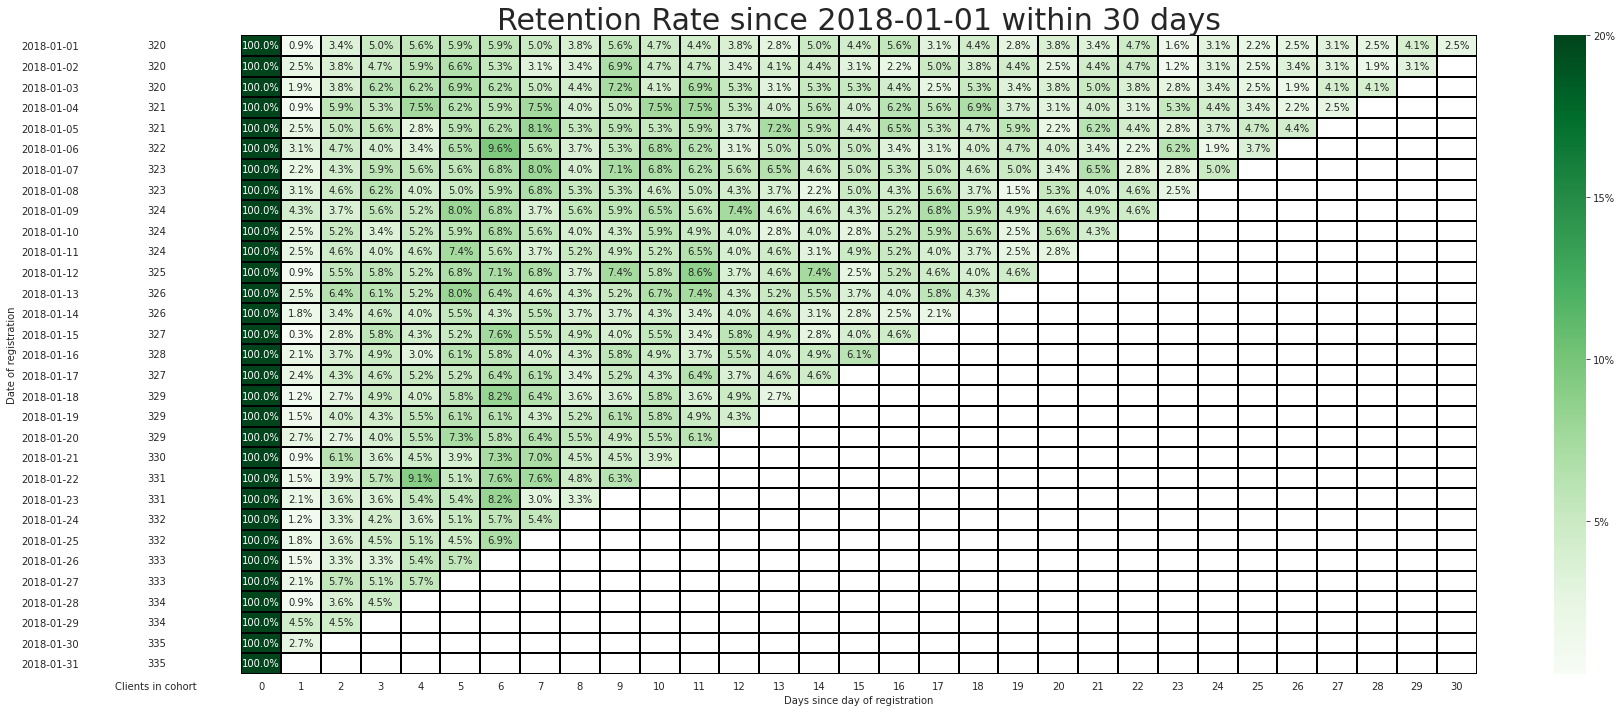

In [6]:
retention_count(reg, auth, '2018-01-01', 30)







## Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [7]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import statsmodels.api as sm
import pylab

from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import chi2_contingency, chi2
import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Приступим.
Первым делом подгрузим имеющиемся данные, посмотрим описательные характеристики, проведем предобработку, проверим, присутствуют ли пропущенные значения в данных, поменяем типы данных, если это необходимо.

In [8]:
AB = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/12gk_ATEeBZm4A', sep=';') 
print('--------------------------------------------------------------')
AB.head()
print('--------------------------------------------------------------')
AB.info()
print('--------------------------------------------------------------')
AB.isnull().sum()
print('--------------------------------------------------------------')
AB.duplicated().sum()

--------------------------------------------------------------


,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


--------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB
--------------------------------------------------------------


user_id      0
revenue      0
testgroup    0
dtype: int64

--------------------------------------------------------------


0

Видим, что с данными все в порядке. Также видим, что в колонке testgroup - 2 типа (группы).

Проверим условия задачи. Проверим, что число пользователей и число платящих пользователей - как в условии.
\
И таким образом определим, какая из групп a и b является тестовой, а какая контрольной. 


In [9]:
print('Кол-во игроков в группе a -', AB.query('testgroup == "a"').shape[0])
print('Кол-во платящих игроков в группе a -', AB.query('testgroup == "a" and revenue > 0').shape[0])
print('Кол-во игроков в группе b - ', AB.query('testgroup == "b"').shape[0])
print('Кол-во платящих игроков в группе b -', AB.query('testgroup == "b" and revenue > 0').shape[0])

Кол-во игроков в группе a - 202103
Кол-во платящих игроков в группе a - 1928
Кол-во игроков в группе b -  202667
Кол-во платящих игроков в группе b - 1805


Таким образом, группа a является контрольной. Группа b является тестовой.

Для принятия решения будем анализировать следующие важные метрики: ARPU, ARPPU и CR.
\
Соберем в одну таблицу значения данных метрик для наших групп.

In [10]:
ARPU = AB.groupby('testgroup', as_index = False) \
    .agg({'user_id': 'count', 'revenue': 'mean'}) \
    .round(2) \
    .rename(columns = {'user_id': 'users', 'revenue': 'ARPU'})

ARPPU = AB.query('revenue > 0') \
    .groupby('testgroup', as_index = False) \
    .agg({'user_id': 'count', 'revenue': 'mean'}) \
    .round(2) \
    .rename(columns = {'user_id': 'paying_users', 'revenue': 'ARPPU'})

metrics = ARPU.merge(ARPPU, on = 'testgroup')
metrics['CR, %'] = round((metrics.paying_users / metrics.users) * 100, 2)

metrics = metrics.iloc[:, [0,1,3,2,4,5]]
metrics


,testgroup,users,paying_users,ARPU,ARPPU,"CR, %"
0,a,202103,1928,25.41,2664.00,0.95
1,b,202667,1805,26.75,3003.66,0.89


In [11]:
diff_ARPU = ((26.75 - 25.41) / 26.75) * 100
print('diff_ARPU =', diff_ARPU)
diff_ARPPU = ((3003.66 - 2664) / 3003.66) * 100
print('diff_ARPPU =', diff_ARPPU)
diff_CR = 0.89 - 0.95
print('diff_CR =', diff_CR)

diff_ARPU = 5.009345794392523
diff_ARPPU = 11.308203991130817
diff_CR = -0.05999999999999994


Видим, что ARPU контрольной группы на 5 % меньше, чем у тестовой. ARPPU контрольной группы на 11.3 % меньше, чем у тестовой. Конверсия в контрольной группе больше на 0,06%, чем в тестовой.
\
Посмотрим на распределения в наших группах.

<Figure size 720x1080 with 0 Axes>

Text(0.5, 1.0, 'Count of users by groups')

Text(0.5, 0, 'Revenue')

Text(0, 0.5, '')

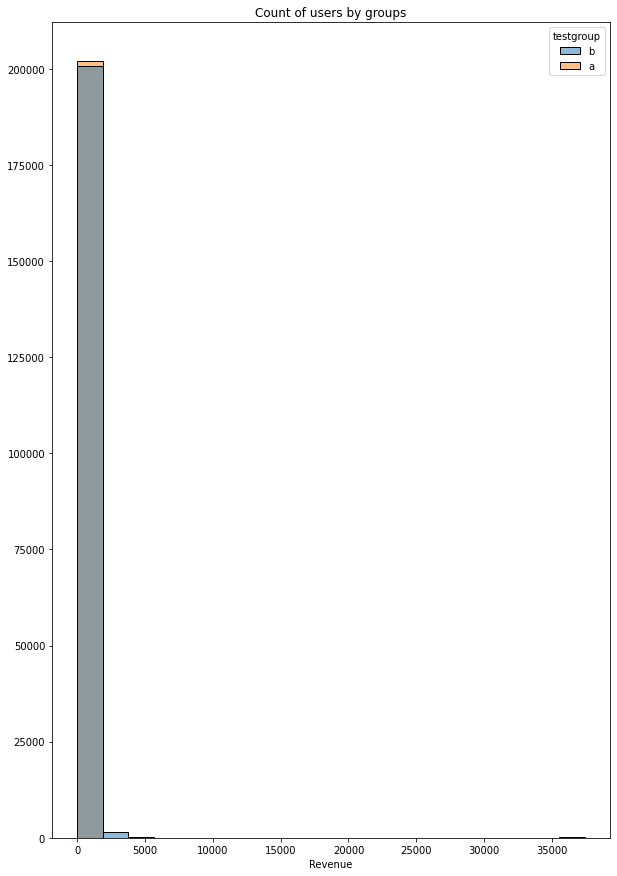

In [12]:
plt.figure(figsize=(10, 15))
sns.histplot(x = 'revenue', data = AB, hue = 'testgroup').set_title('Count of users by groups')
plt.xlabel('Revenue')
plt.ylabel('')

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Count of paying users by groups')

Text(0.5, 0, 'Revenue')

Text(0, 0.5, '')

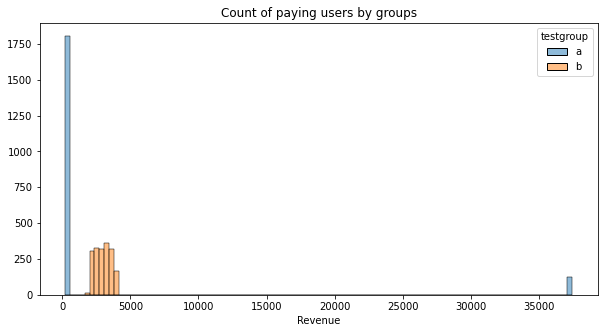

In [13]:
plt.figure(figsize=(10, 5))
sns.histplot(x = 'revenue', data = AB.query('revenue != 0'), hue = 'testgroup').set_title('Count of paying users by groups')
plt.xlabel('Revenue')
plt.ylabel('')

Из графика видно, что распределение ни в одной из групп не является нормальным. 
\
Помимо этого в контрольной группе можно выделить две подгруппы - заплативших очень мало и, наоборот, очень много.
\
В тестовой группе все пользователи платят менее 5000, а в контрольной отдельной группой можно выделить группу пользователей (123 человека (6.4 %)), вклад от которой в доход составялет практически 90 %:

In [14]:
a = AB.query('testgroup == "a" and revenue > 0')
b = AB.query('testgroup == "b" and revenue > 0')

In [15]:
a1 = a.query('revenue > 5000').user_id.count()
print('"Многоплатящие" пользователи в контрольной группе - ', a1)
a11 = a.user_id.count()
print('"Многоплатящие" пользователи в контрольной группе (% от числа пользователей) - ', round(a1 / a11 * 100, 2), '%')
a111 = round(a.query('revenue > 5000').revenue.sum() / a.revenue.sum() * 100, 2)
print('Вклад в доход в контрольной группе от "многоплатящих" пользователей -', a111, '%')

"Многоплатящие" пользователи в контрольной группе -  123
"Многоплатящие" пользователи в контрольной группе (% от числа пользователей) -  6.38 %
Вклад в доход в контрольной группе от "многоплатящих" пользователей - 89.37 %


Если посмотреть на полученную выше таблицу с метриками, то можно заметить интересный момент, что число платящих пользователей в наших группах тоже отличаются на 123 человека. И как раз в контрольной группе на 123 платящего пользователя больше.


Если посмотреть на описательные характеристики в наших группах. Сначала исходные. А потом в предположении, что при дизайне A/B теста могла закрасться ошибка (уберем из рассмотрения в контрольной группе "многоплатящих").

In [16]:
a.revenue.describe()
b.revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [17]:
a.query('revenue < 5000').revenue.describe()
b.revenue.describe()

count    1805.000000
mean      302.458172
std        57.914246
min       200.000000
25%       254.000000
50%       305.000000
75%       352.000000
max       400.000000
Name: revenue, dtype: float64

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

При рассмотрении данных без "Многоплатящих" пользователей виден интересный факт. Все характеристики отличаются практически в 10 раз. Что также говорит о некой "странности" дизайна A\B теста. Может быть это фишка компании - иметь такую группу пользователей. Однако, исходных данных недостаточно для того, чтобы просто выкинуть ее из рассмотрения, поэтому продолжим анализ вместе с ней.

Как мы уже заметили выше - распределения для обеих групп не являются нормальным. Однако, для полного удостоверения в этом проведем normaltest.

In [18]:
stats.normaltest(AB.query('testgroup == "a"').revenue)
stats.normaltest(AB.query('testgroup == "b"').revenue)
stats.normaltest(a.revenue)
stats.normaltest(b.revenue)

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

Видим, что и в случае рассмотрения всех пользователей в каждой группе, и в случае рассмотрения только платящих пользователей в каждой группе normaltest также говорит нам о ненормальности распределений.

Проверим гомогенность дисперсий наших выборок с помощью критерия Левена.

In [19]:
stats.levene(AB.query('testgroup == "a"').revenue, AB.query('testgroup == "b"').revenue)
stats.levene(a.revenue, b.revenue)

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

При рассмотрении всех пользователей дисперсии гомогенны. При рассмотрении только платящих - нет.

Можем ли мы применить для сравнения ARPU, ARPPU в группах t-тест?
\
С одной стороны - распределения у нас ненормальны. Плюс - в одном из случаев негомоггенны дисперсии.
\
Однако, один из случаев, когда t-тест применим - распределение может быть неравномерным, дисперсия неизвестна и выборка большая (больше 30 как принято).
\
Для того, чтобы использовать данный случай для применения t-теста нам осталось только проверить нормальность распределения средних.
\
Сделаем это.

In [20]:
def mean_distribution(df_1, df_2, boot_it, statistic = np.mean):

    boot_len_a = len(df_1)
    boot_len_b = len(df_2)
    
    boot_df_shapiro_a = [] 
    boot_df_shapiro_b = []
    
    for i in tqdm(range(boot_it)):
        
        # извлечем подвыборки
        
        samples_a = df_1.revenue.sample(boot_len_a, replace = True).values
        
        samples_b = df_2.revenue.sample(boot_len_b, replace = True).values
        
        # добавляем средние значения в списки выше
        
        boot_df_shapiro_a.append(statistic(samples_a))
        boot_df_shapiro_b.append(statistic(samples_b))
        
    # Применяем критерий Шапиро-Уилка на каждом из списков
    # Нулевая гипотеза - распределение нормально
    # Альтернативная - распределение не нормальное
    
    shapiro_a = scipy.stats.shapiro(boot_df_shapiro_a)
    shapiro_b = scipy.stats.shapiro(boot_df_shapiro_b)
    
    # Для визуализации
    
    pd_boot_data_a = pd.DataFrame(boot_df_shapiro_a)
    pd_boot_data_b = pd.DataFrame(boot_df_shapiro_b)
    
    plt.hist(pd_boot_data_a[0], bins = 50)
    plt.hist(pd_boot_data_b[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of mean distribution")
    plt.show()
    
    # Вернем значения Шапиро-Уилка
    
    return shapiro_a, shapiro_b

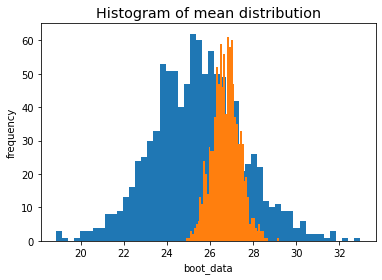

(ShapiroResult(statistic=0.9974434971809387, pvalue=0.11840930581092834),
 ShapiroResult(statistic=0.9982408881187439, pvalue=0.39850422739982605))

In [21]:
mean_distribution(AB.query('testgroup == "a"'), AB.query('testgroup == "b"'), 1000)

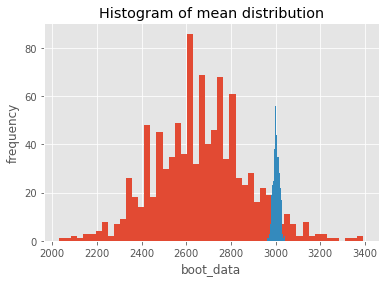

(ShapiroResult(statistic=0.9971511363983154, pvalue=0.07337246090173721),
 ShapiroResult(statistic=0.9986748695373535, pvalue=0.6716021299362183))

In [22]:
mean_distribution(a, b, 1000)

Исходя из рассмотренного распределения средних внутри групп как среди всех пользователей, так и исключительно платящих пользователей - они имеют нормальное распределение (p-value достатночно намного превышает 0.05, отклонить нулевую гипотезу нет оснований).
\
Таким образом, мы можем применить t-тест для ARPU, ARPPU.

H0 - статистически значимых различий нет;
H1 - есть статистически значимые различия

In [23]:
print('t-тест для ARPU:')
scipy.stats.ttest_ind(AB.query('testgroup == "a"').revenue, AB.query('testgroup == "b"').revenue)

t-тест для ARPU:


Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

In [24]:
print('t-тест для ARPPU:')
scipy.stats.ttest_ind(a.revenue, b.revenue)

t-тест для ARPPU:


Ttest_indResult(statistic=-1.5917100176862002, pvalue=0.11153459157259504)

Таким образом, в обоих случаях p-value > 0.05, а следовательно мы не можем отклонить H0, а значит - статистически значимых различий нет.

Замечание. 
\
Также для исследования ARPU, ARPPU можно было использовать метод бутстрап (приведем для примера).

In [25]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа 
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

Применим bootstrap (расчет через среднее значение) для наших изначальных двух групп. Построим гистограмму, а также рассчитаем p-value

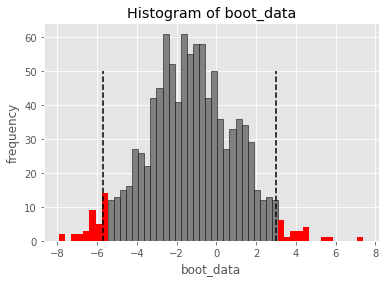

In [26]:
booted_data_mean_ARPU = get_bootstrap(AB[AB.testgroup == "a"].revenue, 
                                     AB[AB.testgroup == "b"].revenue, 
                                     boot_it = 1000,
                                     statistic = np.mean)

In [27]:
booted_data_mean_ARPU["p_value"] 

0.5645057323543581

Из полученного графика видно, что 0 попадает в доверительный интервал, то есть статистической разницы по ARPU мы не выявили.
\
Также и по p-value, которое > 0.05, можно сказать об отсутствии статистически значимых различий ARPU между группами.

Применим бутстрап для исследования ARPPU (платящих пользователей).

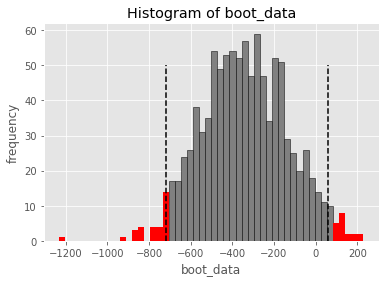

In [28]:
booted_data_mean_ARPPU = get_bootstrap(a.revenue, 
                                     b.revenue, 
                                     boot_it = 1000,
                                     statistic = np.mean)

In [29]:
booted_data_mean_ARPPU["p_value"] 

0.0961906207636896

Как и в случае с ARPU на графике 0 попадает в доверительный интервал, то есть статистической разницы по ARPPU также нет.
Как и по p-value, которое больше 0.05

Таким образом, мы видим, что и при использовании бутстрапа, также, как и при использовании t-теста, мы не получили стат значимых различий ARPU, ARPPU между группами.

Для анализа CR применим критерий хи-квадрат.
\
H0 - статистически значимых различий нет;
H1 - есть статистически значимые различия

In [30]:
AB['paying'] = np.where(AB.revenue > 0, 1, 0)
pd.crosstab(AB.paying, AB.testgroup)
print('--------------------------------------------------------------')
stat, p, dof, expected = scipy.stats.chi2_contingency(pd.crosstab(AB.testgroup, AB.paying))
print('Значения статистики и p-value для критерия хи-квадрат')
stat, p 
print('--------------------------------------------------------------')
prob = 0.95
critical = scipy.stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

testgroup,a,b
paying,,
0,200175,200862
1,1928,1805


--------------------------------------------------------------
Значения статистики и p-value для критерия хи-квадрат


(4.374729521260405, 0.03647561892312613)

--------------------------------------------------------------
Отклоняем H0


Таким образом, при анализе конверсий мы получаем, что различия между группами статистически значимы.

 
 
## Выводы:

Стоит сразу сказать, что распределения в наших подгруппах носят значительно разный характер. В тестовой группе, пусть распределение и не является нормальным, все пользователи платят в пределх 2 - 4 тысяч. В контрольной же группе более 90 % пользователей платят очень маленькие суммы, а небольшая подгруппа огромные суммы, при этом вклад от которых составялет почти 90 %.
\
\
Есть и остаются вопросы к самому дизайну A\B теста. К тому, какие желания важнее для фирмы.
Можно держаться практически за всех пользователей, и они будут платить "средние" сумма - тогда набор предложений, возможных акций от фирмы будет один.
\
\
Можно пойти по другому пути и больше внимания уделять многоплатящим пользователям - другой набор акций и предложений.
\
\
Самое правильное решение - все переделать - провести сплитование правильным образом и повторить тест.
\
\
С точки зрения проведенного анализа теста (t-тест и бутсрап для ARPU, ARPPU, критерий хи-квадрат для CR) по имеющимся исходным данным (без выкидывания "многоплатящих" пользователей):
\
\
Статистически значимых различий в ARPU, ARPPU между контрольной и тестовой группой не выявлено.
\
\
Выявлены статистически значимые различия в CR между группами. Причем в контрольной группе показатель выше, а значит, нужно оставить тот набор предложенй, что был.
\
\
P.S. На свое усмотрение я бы предпочел вариант, в котором, да, мы потеряем в конверсии, однако, получим более надежный и стабильный доход. Как основной момент такого выбора - в случае потери даже нескольких пользователей во втором варианте - велика вероятность высокой потери прибыли, если эти пользователи окажутся из подгруппы многоплатящих.





## Задание 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

## Первый случай

Бизнес метрики на мой взгляд должны быть следующими:

1. DAU, WAU, MAU - количество уникальных пользователей за сутки/неделю/месяц. Можно сравнить количество пользователей в дни с тематическими событиями и в обычные дни.

2. CR - можно оценить влияние ивента на данный показатель. Сравнивать с тем, что было до ивента. (Думаю, что стоит смотреть ежедневно).

3. ARPU и ARPPU - можно оценить влияние ивента (например, будет ли пользователь становиться платящим, чтобы проходить трудные задания с целью получить лучшие награды), в целом оценить, прибыльные ли ивент для компании или нет.

4. Retention - можно посмотреть, будут ли пользователи чаще заходить в игру во время (и как изменится показатель после окончания ивента) проведения ивента. Анализ заинтересованности пользователями ивентом. Проверять в зависимости от длительности ивента (день, неделя).

Метрики ниже уже больше относятся к "техническим", но их тоже стоит отслеживать:

5. Stickiness - сравнить "липкость" в обычные дни и в дни с ивентами.

6. Session и ASD — время, проведенное пользователем в мобильном приложении/среднее время сессий за период времени. Можно посмотреть, будет ли пользователь проводить в приложении больше времени во время ивента.

7. Количество попыток на прохождение уровня.

8. Максимальный уровень, до которого смогли добраться. Можно посмотреть, что можно изменить, чтобы не терять пользователей, если уровень окажется "непроходимым".

Все метрики нужно смотреть по ходу ивента, но и не забывать посмотреть на них и какое-то время после, чтобы проанализировать прошедший ивент, понять, что было хорошо, что плохо. И получить возможность усовершенствовать для следующего ивента.

## Второй случай

Помимо метрик из первого случая также можно добавить следующие:

1. Посмотреть ОТКАТ пользователей после неудачной попытки (одной, двух, трех и т.д.).


2. Выяснить УРОВНИ, на которыз чаще всего происходят откаты.


3. Найти "ТОЧКУ НЕВОЗВРАТА" - среднее число откатов на пользователя - после какого количества неудачных попыток пользователь перестает заходить в игру.

Особенно нужно смотреть на показатель retention в случае усложнения. Основные дополнительные метрики в случае "усложнения" нацелены на то, чтобы понимать, когда у нас происходит момент, что мы начинаем терять пользоваелей, и отследить, что нужно поменять, чтобы этого не происходило.